In [ ]:
# https://github.com/gcdart/MulticlassClassifier/blob/master/src/ml/LogisticRegression.java
# https://www.kaggle.com/c/lshtc/discussion/6911#38233 - preprocessing: multilabels comma should not have spaces
# https://www.kaggle.com/c/lshtc/discussion/14048 - dataset statistics
## reading the LWIKI, SWIKI dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import igraph as ig

from pathlib import Path
from tqdm import tqdm #always use this instead of `import tqdm`
# from sklearn.datasets import fetch_rcv1
from scipy.sparse import *
# np.random.seed(123)
import warnings
warnings.simplefilter('ignore')

In [ ]:
import logging
from collections import OrderedDict

logging.basicConfig(level=logging.INFO, )

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing, metrics

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from joblib import Memory
from sklearn.datasets import load_svmlight_file

In [7]:
from scripts.utils.hierarchy import *
from scripts.utils.label_utils import *

%matplotlib inline

In [21]:
T = HierarchyUtils("lwiki/hierarchy/hierarchy.txt", False, False)

In [22]:
v = T.generate_vectors()

this is undirected graph


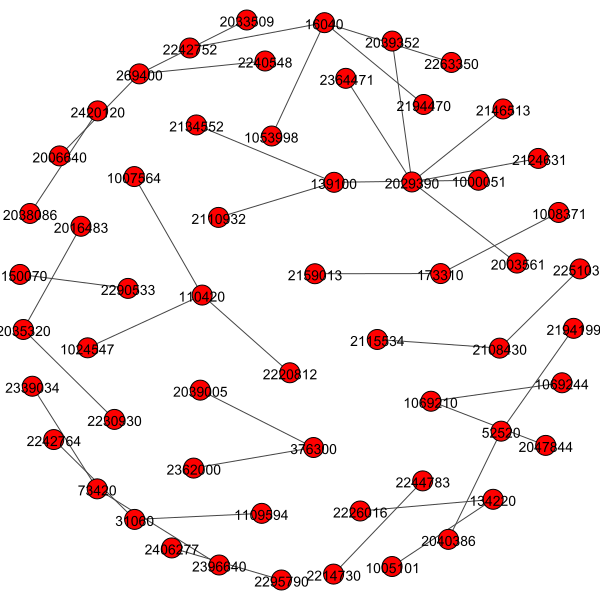

In [24]:
T.draw_graph(40)

In [20]:
v[0][2159645], torch.mean(torch.stack(v[1][2159645], dim=0), dim=0)

(tensor([0.9248, 1.1542, 0.9398, 0.6934, 1.1614, 1.0860, 1.1820, 0.7637, 0.9045,
         1.0152, 0.9988, 1.0473, 1.1361, 0.9788, 1.0164, 0.9373]),
 tensor([0.9251, 1.1545, 0.9400, 0.6937, 1.1617, 1.0863, 1.1823, 0.7640, 0.9047,
         1.0155, 0.9991, 1.0475, 1.1363, 0.9790, 1.0166, 0.9376]))

In [ ]:
mem = Memory("./mycache")
@mem.cache
def get_data(filename):
    
    fname = str(Path(filename))
    fe, ex = os.path.splitext(fname) 

    try:
        data = load_svmlight_file(fname, n_features = 2085162 , multilabel=True, offset = 100000, length = 2800000)
    except:
        # Required: if the input data isn't in the correct libsvm format
        outfile = str(Path("{}_small{}".format(fe, ex)))
#         outfile = str(Path("{}_remapped{}".format(fe, ex)))
        if not os.path.isfile(outfile):
            logging.info("Remapping data to LibSVM format...")
            f = preprocess_libsvm(fname, outfile)
        else:
            logging.info("Using already remapped data...")
            f = outfile
        data = load_svmlight_file(f, multilabel=True, n_features = 2085162 , offset = 100000, length = 2800000)
        
    return data[0], data[1]

In [ ]:
def preprocess_libsvm(input_file, output_file):
    # converts file to the required libsvm format.
    # this is very brute force but can be made faster [IMPROVE]

    file = open(output_file, "w+")
    with open(input_file, "r") as f:
        head = [next(f) for x in range(500)] # retrieve only `n` docs
        for i, line in enumerate(tqdm(head)): # change to f/head depending on your needs
            instance = line.strip().split()
            labels = instance[0]
            doc_dict = OrderedDict()
            temp_dict = {}
            temp_string = ''

            for pair in instance[1:]:
                feat = pair.split(":")
                if int(feat[0]) not in temp_dict:
                    temp_dict[int(feat[0])] = int(feat[1])

            for key in sorted(temp_dict.keys()):
                doc_dict[key] = temp_dict[key]

            for feat, tf in doc_dict.items():
                temp_string = temp_string + "{}:{} ".format(feat, tf)        
            file.write("{} {}\n".format(labels, temp_string))
        file.close()

    return output_file

In [ ]:
def label_extractor(labels):

    leaf_labels = set()
    labels_per_doc = []

    for i in labels:
        labels_per_doc.append(len(i))
        for j in i:
            leaf_labels.add(int(j))
    
    return leaf_labels, labels_per_doc

In [ ]:
mem = Memory("./mycache")
@mem.cache
def rr_reader(filename):
    '''
    create a dataframe from the data-label pair
    '''

    num_entries = 200000
    df = pd.DataFrame()
    
    with open(filename, "r") as f:
#         head = [next(f) for x in range(num_entries)] # retrieve only `n` docs
        for i, line in enumerate(tqdm(f)): # change to f/head depending on your needs
            instance = line.strip().split()
            labels = instance[0]
            doc_dict = OrderedDict()
            temp_dict = {}

            for pair in instance[1:]:
                feat = pair.split(":")
                if int(feat[0]) not in temp_dict:
                    temp_dict[int(feat[0])] = int(feat[1])

            for key in sorted(temp_dict.keys()):
                doc_dict[key] = temp_dict[key]
                
            temp_df = pd.DataFrame(data = [ labels, doc_dict ]).T
            df = df.append(temp_df, ignore_index=True)
    
    df.columns = ["labels", "feat_tf"]
    df["labels"] = df["labels"].apply( lambda x: list(map(int, x.split(",")))  )
    return df

In [ ]:
# df = rr_reader("swiki/data/train.txt")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# todo: fucking hell- represent documents in an embedding space -.-
# after that we can take `each x_i` -.-
def data_parser(dataset, dta):
    # embeds the doc to a D-dim space
    #create doc_vector for each instance
#     tfidfer = TfidfVectorizer()
    idx = list(dataset.index)
    df_x = []
#     for ix in tqdm(idx):
#         twoDarray = list(dataset.loc[ix, "feat_tf"].items())        
#         doc_items = []
#         for item in twoDarray:
#             if item[0] not in doc_items:
#                 if item[1] > 1:
#                     for _ in range(item[1]):
#                         doc_items.append(str(item[0]))
#                 else:
#                     doc_items.append(str(item[0]))

#         tfidfer.fit(doc_items)
#         df_x.append(tfidfer.transform(doc_items))
#             df_x.append(doc_items)
    for ix in tqdm(idx):
        df_x.append(dta[ix].todense())
    dg_x = np.stack(df_x)
    return dg_x

In [ ]:
def largest_feat_n(df):
    return max(df["feat_tf"].apply(lambda x: len(x)))

In [ ]:
# whatiwant = [14661, 71999, 292915, 188756, 131368, 130762, 352578, 395447, 27512, 157031, 33692, 13402, 393382, 390846, 395447, 276114]
whatiwant = [14661, 52361, 401434,316934, 369064]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
clf = SGDClassifier()
# lb = preprocessing.LabelBinarizer(sparse_output=True)
# mb = preprocessing.MultiLabelBinarizer(sparse_output=True)
# le = preprocessing.LabelEncoder()

In [ ]:
 def lookup_table(filename, subset):
        
    p2c_table = {}
    c2p_table = {}
    node2id = OrderedDict()
    id2node = OrderedDict()
    i = 0
    
    with open(filename, "r") as f:
        if not subset:
            head = f
        elif isinstance(subset, int):
            head = [next(f) for x in range(subset)] # retrieve only `n` docs
        else:
            raise ValueError("Incorrect subset type. Enter only False (boolean) or int. Encountered {} type.".format(type(subset)))
        for _, line in enumerate(tqdm(head)):
            split_line = line.strip().split()
            parent_node = int(split_line[0])
            child_node = list(map(int, split_line[1:]))
            
            # map to the respective dicts -> parent:child relationship
            # parent2child lookup table
            if parent_node not in p2c_table:
                p2c_table[parent_node] = [child_node[0]]
            else:
                p2c_table[parent_node].append(child_node[0])
                
            #child2parent lookup table
            if child_node[0] not in c2p_table:
                c2p_table[child_node[0]] = [parent_node]
            else:
                c2p_table[child_node[0]].append(parent_node)
                
            # map parent/child node to a node<->id
            if parent_node not in node2id:
                p_id = i
                node2id[parent_node] = p_id
                id2node[p_id] = parent_node
                i+=1
            else:
                p_id = node2id[parent_node]
                
            if child_node[0] not in node2id:
                c_id = i
                node2id[child_node[0]] = c_id
                id2node[c_id] = child_node[0]      
                i+=1
            else:
                c_id = node2id[child_node[0]]

    pi_parents = set(p2c_table.keys())        
    T_leaves = (c2p_table.keys() - p2c_table.keys()) 
    N_all_nodes = pi_parents.union(T_leaves)
    
    return p2c_table, c2p_table, node2id, id2node, list(pi_parents), list(T_leaves), list(N_all_nodes)

In [ ]:
def hierarchy2graph(p2c_table, node2id):

    edges = []
    for parent, children in p2c_table.items():
        p_id = node2id[parent]
        for child in children:
            c_id = node2id[child]
            edges.append((p_id, c_id))
    vertices = [k for k, v in node2id.items()]
    g = ig.Graph(n=len(node2id), edges=edges, directed=True, vertex_attrs={"name": vertices})
    return g

In [ ]:
def read_hier(filename):
    
    N = set()
    pi = set()
    T = set()
#     this is wrong
    with open(filename, "r") as f:
        for i, line in enumerate(f):
            words = line.strip().split()
            pi.add(int(words[0])) #adding parent node
            T.add(int(words[1])) #adding ALL leaf nodes in the hierarchy
            for w in words:
                N.add(int(w))

    return N, pi, T

In [ ]:
p2c, c2p, n2i, i2n, pi, T, N = lookup_table("swiki/data/cat_hier.txt", subset = False)
p2c_s, c2p_s, n2i_s, i2n_s, pi_s, T_s, N_s = lookup_table("swiki/data/cat_hier.txt", subset = 25)
# w_all_n, rev_all_n = weightparameter(N, 64)

In [ ]:
len(pi) + len(T)

In [ ]:
len(pi) , len(T), len(N)

In [ ]:
Nn, pii, Ti = read_hier("swiki/data/cat_hier.txt")

In [ ]:
print(len(Nn), len(Ti)) # there is one node without any parent
print(Nn.difference(Ti)) # this is the node: this is probably the root node i guess

In [ ]:
len(pii)

In [ ]:
g = hierarchy2graph(p2c_s, n2i_s)

In [ ]:
g.get_diameter()

In [ ]:
l = next(g.bfsiter(3))

In [ ]:
print(l.neighbors())

In [ ]:
print(g)

In [ ]:
ind= g.degree(type="in")

In [ ]:
g.neighbors(n2i[2143406])

In [ ]:
import random

In [ ]:
random.uniform(1,9)

In [ ]:
i2n_s[np.where(np.array(ind) == 0)[0][0]]

In [ ]:
def hierarchy_vectors(graph_obj, ix2node, node2ix, p2c, n):
    
    # maybe even return the depth level of the node while returning the vector?
    # ensure that all the vectors are unique
    node2vec = {}
    depth_level = [1e-5, 1e-4, 1e-4, 1e-3, 1e-3, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
    
    # 1. find the root node. in degree = 0
    in_degree = graph_obj.degree(type = "in")
    root_node = ix2node[np.where(np.array(in_degree)==0)[0][0]]
    
    # 2. generate random vector for root
    root_vector = np.random.randn(n,)
    
    for parent, children in p2c.items():
        if parent == root_node:
            node2vec[parent] = root_vector

        # 3. find children
        # 4. generate random vectors for children of parent (neighbours) at uniform randomness
        for each_child in children:
            i = len(graph_obj.get_shortest_paths(node2ix[root_node], node2ix[each_child])[0]) - 2
            rand = random.uniform(1, 9)*depth_level[i]
            if each_child not in node2vec:
                curr_vector = node2vec[parent] + rand
                node2vec[each_child] = curr_vector

    return node2vec

In [ ]:
g = hierarchy2graph(p2c, n2i)
n2v = hierarchy_vectors(g, i2n, n2i, p2c, 16)

In [ ]:
len(g.get_shortest_paths(0, 69)[0])-2

In [ ]:
g.get_diameter()

In [ ]:
p2c_s[2143406]

In [ ]:
len(n2v)

In [ ]:
p2c_s, c2p_s, n2i_s, i2n_s, pi_s, T_s, N_s = lookup_table("swiki/data/cat_hier.txt", subset = 100)
g = hierarchy2graph(p2c_s, n2i_s)

In [ ]:
g.get_diameter() # returns indices of the smallest node number at each level

In [ ]:
g.neighbors(70)

In [ ]:
i2n[70]

In [ ]:
layout = g.layout("kk")
g.vs["label"] = g.vs["name"]
ig.plot(g, layout = layout)

<img src = "image.png">

In [ ]:
def weightparameter(N_all_nodes, size_n):
    
    # randomly initialize weights for all nodes instead of taking user input [assumption]
    w_all_n = {}
    rev_mapping_w = {}
    for n in N_all_nodes:
        temp_rand = np.random.randn(size_n,1)
        if n not in w_all_n:
            w_all_n[n] = temp_rand
        if temp_rand not in rev_mapping_w:
            rev_mapping_w[temp_rand] = n
    return w_all_n, rev_mapping_w

In [ ]:
def function_gradient(w_n, w_node, x, data):
    
    w_pi_n = w_all_n[c2p[w_node][0]]
    
    C = 1 # by default
    one = w_n - w_pi_n
    norm_w = np.linalg.norm(x = one, ord = 'fro', keepdims = False)
    
#     g = []
#     g = g.reshape((-1,1))
    y_in = -1 * np.ones((w_n.shape))

    for i, j in enumerate(data.index):
        if w_node in data.loc[j, "labels"]:
            y_in[i] = 1
            print("yes", w_node, data.loc[j, "labels"])

    y_w_x = np.dot(y_in, np.dot(np.transpose(w_n), np.transpose(x)))

    # eqn 3.8
    obj = C * np.sum(np.log(1+np.exp(-y_w_x)), axis = 1, keepdims = True)
    assert w_n.shape == obj.shape
    
#     y_x = np.dot(y_in.T, x.T)
#     two = C*(1/(1+np.exp(y_w_x)))*y_x
#     assert(one.shape == two.shape)
#     g.append(one - two)

    min_wn = norm_w + obj
    
    return min_wn      

In [ ]:
function_gradient

In [ ]:
fff.shape

In [ ]:
from scipy import optimize

In [ ]:
def objective_lr(data, w_node, lmbda, eps, maxfn, fff):
    m = 5
    f = 0
    xtol = 1e-30
    w_n = w_all_n[w_node]
    maxfn = 0
    init_x = [2, 2]
    largest_n = largest_feat_n(data)
    n = max(len(w_n), largest_n)
    
    x = fff
    g = np.zeros(x.shape)
    while(maxfn < 10):
        
#         f = function_gradient(w_n, w_node, x, data)
#         try:
        optimize.minimize(fun = function_gradient, x0 = init_x, args=(w_n), method='L-BFGS-B', tol=xtol, options={'disp': True, 'eps': eps })
#         except:
#             print("didn't converge")
            
        maxfn +=1

In [ ]:
max(N)

In [ ]:
large_n = largest_feat_n(small_df)

In [ ]:
gg.shape

In [ ]:
# result_w = np.zeros((len(N_s),1))
# while(1):
result_w = {}

for n in N_s:    
    print(n)
    # check if the node has a parent
    if n not in c2p:
        w_pi_n = 0 # if the node has no parent then it's the root node. assign it w=0
    else:
        w_pi_n = w_all_n[n] 
    
    # if n is not leaf node
    if n not in T_s:
        # update w_n using eqn 3.3 or 4
        mod_C_n = len(p2c[n]) # |C_n|
        sum_w_c = 0 
        for c in p2c[n]:
            sum_w_c += w_all_n[c]
            
        if n not in result_w:
            result_w[n] = 1/(mod_C_n + 1) * (w_pi_n + sum_w_c)
    # else: n is a leaf node
    else:
        #optimize using lbfgs eqn 3.8, 3.9 or 8
        lmbda = 1
        eps = 1e-4
        maxfn = 10
        w_n = w_all_n[n]
        lr_function = objective_lr(small_df, n, lmbda, eps, maxfn, gg) ##
#         g = function_g() ##
        print("over")
    print("ove")
print("ov")

In [ ]:
len(pi), len(T), len(N)

In [ ]:
result_w